In [320]:
import pandas as pd
import math
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yasa
from sklearn.pipeline import Pipeline
from mne.decoding import CSP
from sklearn.model_selection import ShuffleSplit, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

events = np.loadtxt('p1_high1_trig.txt', delimiter=',')
# events = np.squeeze(events.values.tolist())
data = np.loadtxt('p1_high1.txt', delimiter=',')

print(events.shape, data.shape)

fs = 256
window_size = 40
channels = 8

(39032,) (39032, 8)


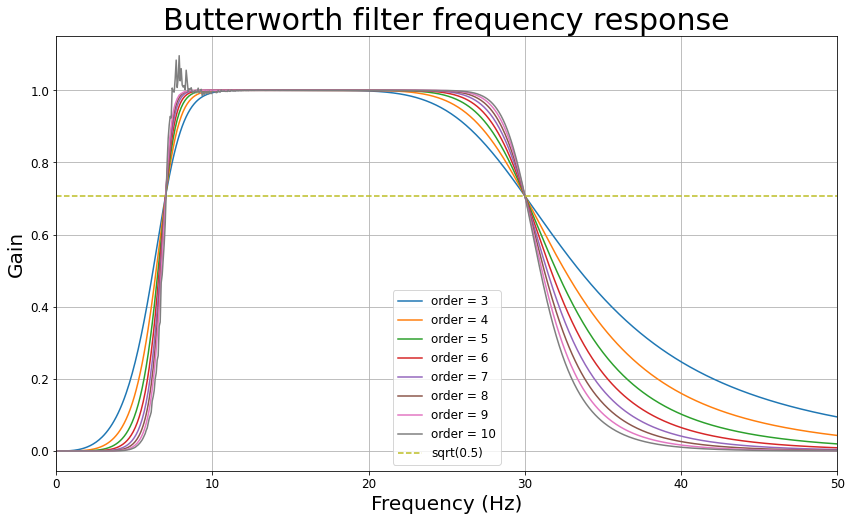

In [321]:
from scipy.signal import welch, freqz, butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


# Plot frequency response, spectrum for unfiltered, test it on C3

# Define band
low = 7
high = 30

# Frequency response
plt.figure(1, figsize=(14, 8))
plt.clf()
for order in [3, 4, 5, 6, 7, 8, 9, 10]:
    b, a = butter_bandpass(low-margin, high+margin, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.title("Butterworth filter frequency response", fontsize=30)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.xlim([0, 50])
plt.ylabel('Gain', fontsize=20)
plt.grid(True)
plt.legend(loc='best')



In [322]:
# for i in range(data.shape[1]):
#     data[:, i] = butter_bandpass_filter(data[:, i], low, high, fs, order=9)


In [323]:
non_target = np.zeros((channels, window_size))
target = np.zeros((channels, window_size))

non_target_count = 0 
target_count = 0

avg_non_target = np.zeros((channels, window_size))
avg_target = np.zeros((channels, window_size))

for i in range(events.shape[0]):
    if (events[i] == 1):
        non_target_count += 1
        non_target = np.append(non_target, data[i+40:i+80, :].T, axis=1)
        
    elif (events[i] == 2):
        target_count += 1
        target = np.append(target, data[i+40:i+80, :].T, axis=1)
    
    
non_target = non_target[:, window_size:]
target = target[:, window_size:]

all_trials = np.append(target, non_target, axis=1)

print(non_target.shape, all_trials.shape, target_count, non_target_count)

(8, 2400) (8, 4800) 60 60


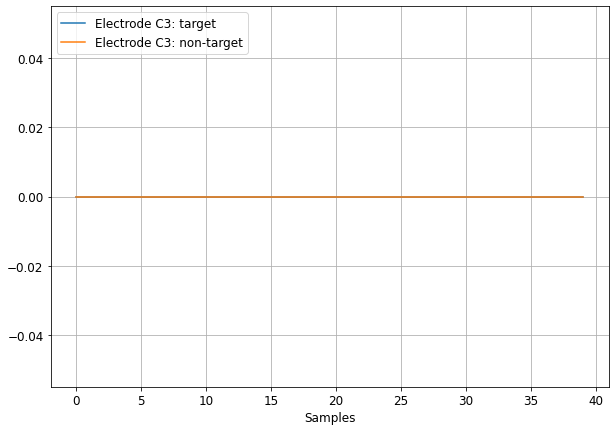

In [324]:
# plot
time = [i for i in range(window_size)]

plt.figure(1, figsize=(10, 7))
plt.clf()
plt.plot(time, avg_target[1, :], label='Electrode C3: target')
plt.plot(time, avg_non_target[1, :], label='Electrode C3: non-target' )

plt.xlabel('Samples')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

In [325]:
# Create function to process eeg
b = 200
bp_trials = np.zeros((8, 1))

while (b <= all_trials.shape[1]):
    data_bp = all_trials[:, b-65:b]
    data_bp = yasa.bandpower(data_bp, fs, relative=False)['TotalAbsPow']
    data_bp = data_bp.values.reshape((data_bp.shape[0], 1))
    bp_trials = np.append(bp_trials, data_bp, axis=1)
    
    b += 10
    
bp_trials = bp_trials[:, 1:]
print(bp_trials.shape)
print(bp_trials)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 1024 is greater than input length  = 65, using nperseg = 65
  warnings.warn('nperseg = {0:d} is greater than input length '


(8, 461)
[[ 983.71923301  297.84620295  138.60318261 ...  498.97228274
   855.53424529  652.18763611]
 [  51.30411345  177.46685009 1056.41204634 ...  655.11603557
  1190.00686935  955.85839334]
 [ 101.83741211  186.0426314  1186.7171944  ...   67.54105377
    34.11872751   23.11280387]
 ...
 [ 137.38206894  162.96310427  965.35669477 ...   72.34302728
    56.96499613   51.3818729 ]
 [ 755.74733162  201.4447663    56.00388438 ...  466.32475509
   724.35107154  551.34293607]
 [ 247.14020113  389.26494557 1574.52308011 ...   32.09081604
    13.41799517   12.44052009]]


In [326]:
# half1 = bp_trials[:, int(bp_trials.shape[1]/2):]
# half2 = bp_trials[:, :int(bp_trials.shape[1]/2)]

# bp_trials[:, 0::2] = half1
# bp_trials[:, 1::2] = half2

# create y vector
y = np.concatenate((np.ones(int(all_trials.shape[1]/2)), np.zeros(int(all_trials.shape[1]/2))))
print(y.shape)

(4800,)


[[1420    4]
 [   8 1448]]


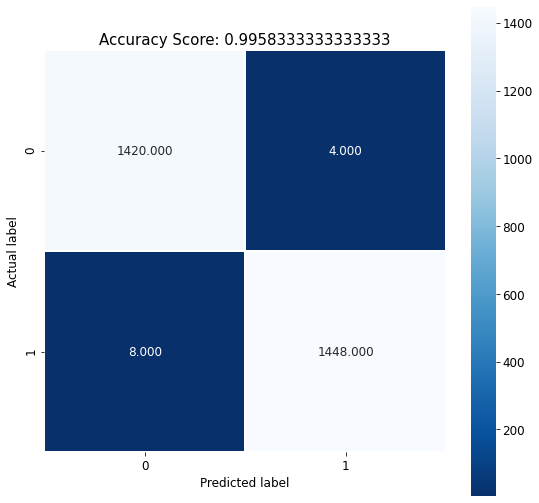

In [327]:
# classify

x_train, x_test, y_train, y_test = train_test_split(all_trials.T, y, test_size=0.6, shuffle=True, random_state=1)

scaler = StandardScaler()
scaler.fit(x_train)    
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

model = MLPClassifier(activation='relu', 
                      hidden_layer_sizes=(300, 150), 
                      alpha=0.0003,
                      learning_rate='adaptive')
model.fit(x_train, y_train)

# Make predictions on entire test set
predictions = model.predict(x_test)

# Use score method to get accuracy of model
score = model.score(x_test, y_test)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {1}'.format("Neural Net", score)
plt.title(all_sample_title, size = 15);